In [4]:
from baseline_model_10h import ALL_10h
import os
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ALL_10h()
#model = torch.load('tfboard/mesa/ResHybridAtt_OLD/our_10h_all_cnn_200/saved_models/fold_0_epoch_46.pth').cuda()

#model = torch.load('tfboard/mesa/ResHybridAtt/Comparative_Experiment_semi/our/our_semi_1/saved_models/fold_0_epoch_3.pth').cuda()

#model = torch.load('tfboard/mesa/ResHybridAtt_OLD/our_10h_all_cnn_200/saved_models/fold_0_epoch_46.pth')

model = torch.load('tfboard/mesa/ResHybridAtt/cnn_20/saved_models/fold_0_epoch_18.pth')


In [53]:
data_path = '../da300s/'
with open(data_path + 'cfs/10h_input/train_all_label_frag_100.pkl', 'rb') as f:
    lab = pickle.load(f)

In [66]:
count = np.zeros(4)

In [1]:
import torch
class_counts = torch.tensor([726, 2555, 886, 1315])

In [3]:
[i / class_counts.sum()  for i in class_counts]

[tensor(0.1324), tensor(0.4661), tensor(0.1616), tensor(0.2399)]

In [78]:
for i in range(len(lab)):
    for j in range(4):
        count[j] = count[j] + np.sum(np.array(lab[i]) == j)

In [79]:
count

array([46774., 48962., 15946., 14361.])

In [77]:
np.sum(np.array(lab[i])==0)

939

In [68]:
cnt

array([939, 327])

In [5]:
class Load_10h_Dataset(Dataset):
    def __init__(self, mode):
        super(Load_10h_Dataset, self).__init__()
        
        data_path = '../da300s/'
        
        self.mode = mode
        mode = mode + '_all'
        
        self.mask = torch.ones(32, dtype=torch.bool)
        self.mask[[6, 14, 22, 30]] = False
        
        with open(data_path + 'mesa/10h_input/train_fea_conseq_200.pkl', 'rb') as f:#1354
            self.fea = pickle.load(f)
        with open(data_path + 'mesa/10h_input/train_sig_conseq_200.pkl', 'rb') as f:
            self.sig = pickle.load(f)
        with open(data_path + 'mesa/10h_input/train_all_ppg_200.pkl', 'rb') as f:
            self.ppg = pickle.load(f)
        with open(data_path + 'mesa/10h_input/train_all_label_frag_200.pkl', 'rb') as f:
            self.test_label = pickle.load(f)
        with open(data_path + 'mesa/10h_input/train_ahi_label_200.pkl', 'rb') as f:
            self.ahi_label = pickle.load(f)

        del_list = list()
        for i in range(len(self.ahi_label)):
            if (self.ahi_label[i].shape[0])==0:
                del_list.append(i)
        
        for index in sorted(del_list, reverse=True):
            del self.ahi_label[index]
            del self.test_label[index]
            del self.fea[index]
            del self.sig[index]
            del self.ppg[index]

        self.len = len(self.ppg)#2 * length#label.shape[0]
    def __getitem__(self, index):
        ppg = self.ppg[index].unsqueeze(0)
        sig = self.sig[index]
        fea = self.fea[index][self.mask]
        label = self.test_label[index][0, :1200]
        
        #frag_label = self.test_label[index][1, :1200]
        
        frag_label = torch.tensor(0)
        
        ahi_label = self.ahi_label[index][:1200]
        
        return ppg.float(), sig.float(), fea.float(), label.long(), frag_label.long(), ahi_label.long()
        
    def __len__(self):
        
        return self.len

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=Load_10h_Dataset('train'), batch_size=1,
                                           shuffle=True, pin_memory=True,# drop_last=True,
                                           num_workers=0)

In [404]:
train_loader.__len__()

199

In [4]:
reli_cnt = np.zeros(4, dtype = int)
unreli_cnt = np.zeros(4, dtype = int)

our_cnt = np.zeros(4, dtype = int)
unour_cnt = np.zeros(4, dtype = int)

In [362]:
refea_1 = list()
unrefea_1 = list()

ourfea_1 = list()
adourfea_1 = list()
unourfea_1 = list()

In [15]:
len(refea), len(relabel), len(ourfea), len(ourlabel), len(adourfea), len(adourlabel)

(797, 797, 797, 797, 800, 800)

In [51]:
adourfea[0].shape

torch.Size([768])

In [50]:
label.shape[1]

1056

In [9]:
refea = list()
relabel = list()

ourfea = list()
ourlabel = list()
adourfea = list()
adourlabel = list()

In [10]:
for batch_idx, (ppg, sig, fea, label, frag_label, ahi_label) in enumerate(train_loader):
    if(batch_idx !=22): # 22
        continue
    y_frag = frag_label.squeeze(0)
    y = label.squeeze(0)
    ahi_label = ahi_label.squeeze(0)
    
    y = y #+ y_frag * 4 + ahi_label * 8

    y = y.long().to(device)
    
    ppg = ppg.to(device)
    sig = sig.to(device)
    fea = fea.to(device)
    outputs = model(ppg, sig, fea)
    
    if type(outputs) in (tuple, list):
        
        feature, outputs = outputs[0], outputs[1]

    else:
        feature = outputs

    feature = feature[0, :y.shape[0], :]
    outputs = outputs[0, :y.shape[0], :]
 
    prob_fea = feature
    
    #value, predicted = torch.max(outputs[:, :].data, dim=1)
    posi_list = list()
    for i in range(4):
        posi_list.append(list())
    
    n = len(outputs)
    
    prob_tea_i = outputs.clone()
    
    entropy_i = - torch.sum(prob_tea_i * torch.log(prob_tea_i + 1e-10), dim=1)
    entropy_i = (entropy_i-entropy_i.min())/(entropy_i.max()-entropy_i.min())

    for i in range(4):
        for j in range(len(prob_tea_i)):
            posi_list[i].append(prob_tea_i[j][i]-entropy_i[j])
    
    posi_list = torch.clamp(torch.stack([torch.stack(i) for i in posi_list]), min=0).detach()

    our = list()
    for i in range(4):
        our.append(list())
    
    low_k = int(n * 0.2)
    low_k =  torch.kthvalue(entropy_i, low_k ).values
    value, predicted = torch.max(outputs[:, :].data, dim=1)
    reli = entropy_i < low_k

    #contract loss
    for i in range(4):    
        lab_mean = torch.sum(posi_list[i].unsqueeze(1) * prob_fea, axis = 0)/torch.sum(posi_list[i])
        #lab_mean = lab_mean.detach()
        
        temp = (posi_list[i].unsqueeze(1) * prob_fea + (1 - posi_list[i]).unsqueeze(1) * lab_mean)#[posi_list[i]>0]

        our[i].append(temp)
    
    for i in range(len(y)):
        refea.append(feature[i].cpu().detach().numpy())
        if(reli[i]):
            relabel.append(predicted[i].cpu())#0, 1, 2, 3, 4        预测的四类&低置信度
        else:
            relabel.append(4)
        
        ourfea.append(feature[i].cpu().detach().numpy())#0, 1, 2, 3, 4        预测的四类&低置信度
        if(posi_list[:, i].any()):
            ourlabel.append(predicted[i].cpu())
        else:
            ourlabel.append(4)

        flag = True
        for j in range(4):
            if(posi_list[j][i]):
                adourfea.append(our[j][0][i].cpu().detach().numpy())
                adourlabel.append(j)
                flag = False
        if(flag):
            adourfea.append(feature[i].cpu().detach().numpy())
            adourlabel.append(4)
            
    '''
    for i in range(len(y)):
        if(y[i]==1):
            if(reli[i]):
                refea_1.append(feature[i])#0, 1, 2, 3, 4        预测的四类&低置信度
            else:
                unrefea_1.append(feature[i])

            if(posi_list[1][i]):
                ourfea_1.append(feature[i])#0, 1, 2, 3, 4        预测的四类&低置信度
                adourfea_1.append(our[i])
            else:
                unourfea_1.append(feature[i])
    '''
    #train_loss = 0
    break

In [11]:
all = np.stack(refea + ourfea + adourfea, axis = 0)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev

# 假设你有一些数据
data = all  # 100个样本，50个特征

# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
#data_tsne = tsne.fit_transform(data)

data_tsne = tsne.fit_transform( np.array(ourfea) )

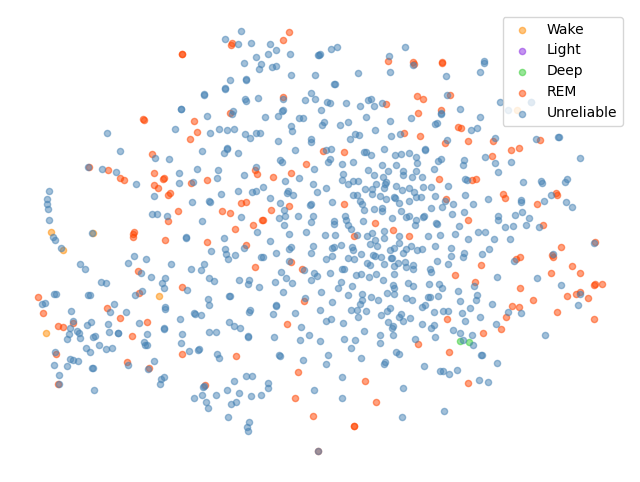

In [8]:
#data_temp = data_tsne
#data_tsne = data_temp[:len(relabel)]
relabel = np.array(relabel)
# 绘制散点图

plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[relabel==0, 0], data_tsne[relabel==0, 1], s=20, alpha=0.5, c = 'darkorange', label='Wake')
plt.scatter(data_tsne[relabel==1, 0], data_tsne[relabel==1, 1], s=20, alpha=0.5, c = 'blueviolet', label='Light')
plt.scatter(data_tsne[relabel==2, 0], data_tsne[relabel==2, 1], s=20, alpha=0.5, c = 'limegreen', label='Deep')
plt.scatter(data_tsne[relabel==3, 0], data_tsne[relabel==3, 1], s=20, alpha=0.5, c = 'orangered', label='REM')
plt.scatter(data_tsne[relabel==4, 0], data_tsne[relabel==4, 1], s=20, alpha=0.5, c = 'steelblue', label='Unreliable')
#plt.scatter(unrefeatsne_1[:, 0], unrefeatsne_1[:, 1], s=20, alpha=0.8, c='steelblue', label='Low Confidence')

# 绘制平滑的曲线
#plt.plot(x_smooth, y_smooth, color='red', linewidth=2, linestyle='--', label='Smoothed Convex Hull')
plt.axis('off')
# 添加标题和标签
#plt.title('20% Threshold Selection', fontsize=20)
#plt.xlabel('t-SNE Component 1')
#plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.savefig('fig3_20.png', dpi=300)  
plt.show()
plt.close()

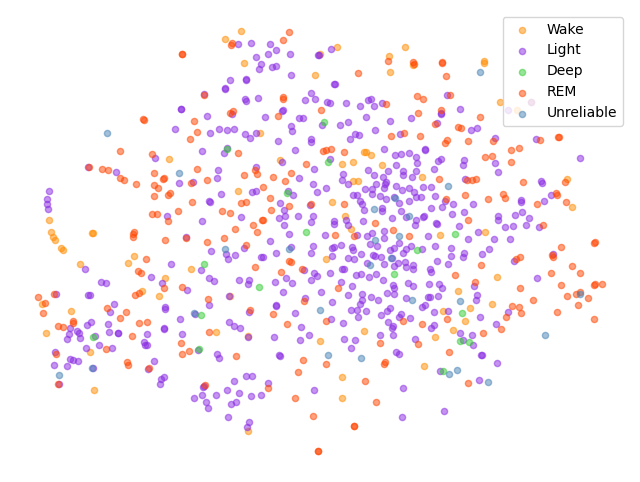

In [9]:
ourlabel = np.array(ourlabel)

#data_tsne = data_temp[len(relabel):len(relabel) + len(ourfea)]

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[ourlabel==0, 0], data_tsne[ourlabel==0, 1], s=20, alpha=0.5, c = 'darkorange', label='Wake')
plt.scatter(data_tsne[ourlabel==1, 0], data_tsne[ourlabel==1, 1], s=20, alpha=0.5, c = 'blueviolet', label='Light')
plt.scatter(data_tsne[ourlabel==2, 0], data_tsne[ourlabel==2, 1], s=20, alpha=0.5, c = 'limegreen', label='Deep')
plt.scatter(data_tsne[ourlabel==3, 0], data_tsne[ourlabel==3, 1], s=20, alpha=0.5, c = 'orangered', label='REM')
plt.scatter(data_tsne[ourlabel==4, 0], data_tsne[ourlabel==4, 1], s=20, alpha=0.5, c = 'steelblue', label='Unreliable')

# 绘制平滑的曲线
#plt.plot(x_smooth, y_smooth, color='red', linewidth=2, linestyle='--', label='Smoothed Convex Hull')
plt.axis('off')
# 添加标题和标签
#plt.title('Our Method Selection', fontsize=16)

#plt.xlabel('t-SNE Component 1')
#plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.savefig('fig3_our.png', dpi=300)  
plt.show()
plt.close()

In [ ]:
len(refea), len(ourfea), len(adourfea)

In [9]:
refeatsne_1 = data_tsne[:len(refea_1)]
unrefeatsne_1 = data_tsne[len(refea_1):len(refea_1) + len(unrefea_1)]
ourfeatsne_1 = data_tsne[len(refea_1) + len(unrefea_1):len(refea_1) + len(unrefea_1) + len(ourfea_1)]
unourfeatsne_1 = data_tsne[len(refea_1) + len(unrefea_1) + len(ourfea_1):len(refea_1) + len(unrefea_1) + len(ourfea_1) + len(unourfea_1)]

adourfeatsne_1 = data_tsne[len(refea_1) + len(unrefea_1) + len(ourfea_1) + len(unourfea_1):
                    len(refea_1) + len(unrefea_1) + len(ourfea_1) + len(unourfea_1) + len(adourfea_1)]

NameError: name 'data_tsne' is not defined

In [ ]:
refeatsne_1 = data_tsne[:len(refea_1)]
unrefeatsne_1 = data_tsne[len(refea_1):len(refea_1) + len(unrefea_1)]
ourfeatsne_1 = data_tsne[len(refea_1) + len(unrefea_1):len(refea_1) + len(unrefea_1) + len(ourfea_1)]
unourfeatsne_1 = data_tsne[len(refea_1) + len(unrefea_1) + len(ourfea_1):len(refea_1) + len(unrefea_1) + len(ourfea_1) + len(unourfea_1)]

adourfeatsne_1 = data_tsne[len(refea_1) + len(unrefea_1) + len(ourfea_1) + len(unourfea_1):
                    len(refea_1) + len(unrefea_1) + len(ourfea_1) + len(unourfea_1) + len(adourfea_1)]

In [75]:

# 计算 Convex Hull
hull = ConvexHull(refeatsne_1)

# 获取 Convex Hull 点的坐标
hull_points = refeatsne_1[hull.vertices]
hull_points = np.vstack([hull_points, hull_points[0]])

# 使用样条插值生成平滑曲线
tck, u = splprep(hull_points.T, s=0)  # s=0表示没有平滑
x_smooth, y_smooth = splev(np.linspace(0, 1, 1000), tck)

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev

# 假设你有一些数据
data = np.array(refea)  # 100个样本，50个特征

# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

In [97]:
data_tsne.shape

(1076, 2)

In [99]:
len(refea), len(relabel), len(ourfea), len(ourlabel), len(adourfea), len(adourlabel)

(1076, 1076, 1076, 1076, 1079, 1079)

In [104]:
relabel = np.array(relabel)

In [26]:
data_tsne[:len(relabel)].shape

(797, 2)

In [27]:
data_tsne[len(relabel):len(relabel) + len(ourfea)].shape

(797, 2)

In [28]:
data_tsne[len(relabel) + len(ourfea):len(relabel) + len(ourfea) + len(adourlabel)].shape

(800, 2)

In [114]:
# 假设你有一些数据
data = np.array(ourfea)  # 100个样本，50个特征

# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

In [122]:
# 假设你有一些数据
data = np.array(adourfea)  # 100个样本，50个特征

# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

In [368]:
adourlabel = np.array(adourlabel)

In [294]:
data_tsne = data_temp[len(relabel) + len(ourfea):len(relabel) + len(ourfea) + len(adourlabel)]

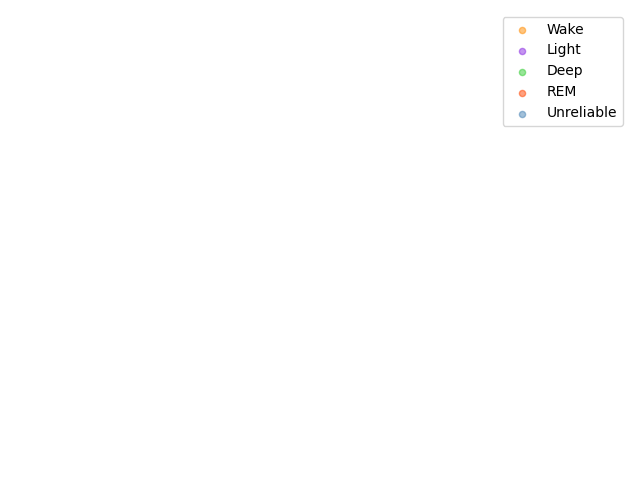

In [10]:
# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[adourlabel==0, 0], data_tsne[adourlabel==0, 1], s=20, alpha=0.5, c = 'darkorange', label='Wake')
plt.scatter(data_tsne[adourlabel==1, 0], data_tsne[adourlabel==1, 1], s=20, alpha=0.5, c = 'blueviolet', label='Light')
plt.scatter(data_tsne[adourlabel==2, 0], data_tsne[adourlabel==2, 1], s=20, alpha=0.5, c = 'limegreen', label='Deep')
plt.scatter(data_tsne[adourlabel==3, 0], data_tsne[adourlabel==3, 1], s=20, alpha=0.5, c = 'orangered', label='REM')
plt.scatter(data_tsne[adourlabel==4, 0], data_tsne[adourlabel==4, 1], s=20, alpha=0.5, c = 'steelblue', label='Unreliable')

# 绘制平滑的曲线
#plt.plot(x_smooth, y_smooth, color='red', linewidth=2, linestyle='--', label='Smoothed Convex Hull')
plt.axis('off')
# 添加标题和标签
#plt.title('Our Method Adjustment', fontsize=16)
#plt.xlabel('t-SNE Component 1')
#plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.savefig('fig3_ouradjust.png', dpi=300)  
plt.show()

In [81]:
# 计算 Convex Hull
hull = ConvexHull(ourfeatsne_1)

# 获取 Convex Hull 点的坐标
hull_points = ourfeatsne_1[hull.vertices]
hull_points = np.vstack([hull_points, hull_points[0]])

# 使用样条插值生成平滑曲线
tck, u = splprep(hull_points.T, s=0)  # s=0表示没有平滑
x_smooth, y_smooth = splev(np.linspace(0, 1, 1000), tck)

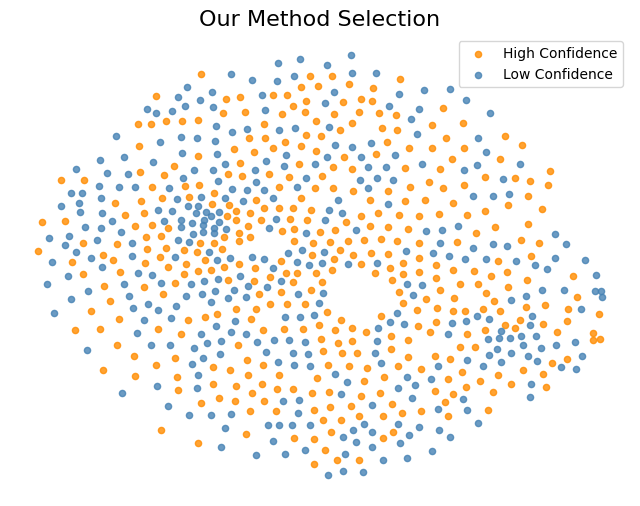

In [138]:
# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(ourfeatsne_1[:, 0], ourfeatsne_1[:, 1], s=20, alpha=0.8, c='darkorange', label='High Confidence')
plt.scatter(unourfeatsne_1[:, 0], unourfeatsne_1[:, 1], s=20, alpha=0.8, c='steelblue', label='Low Confidence')

# 绘制平滑的曲线
#plt.plot(x_smooth, y_smooth, color='red', linewidth=2, linestyle='--', label='Smoothed Convex Hull')
plt.axis('off')
# 添加标题和标签
plt.title('Our Method Selection', fontsize=16)
#plt.xlabel('t-SNE Component 1')
#plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.savefig('fig3_our.png', dpi=300)  
plt.show()
plt.close()

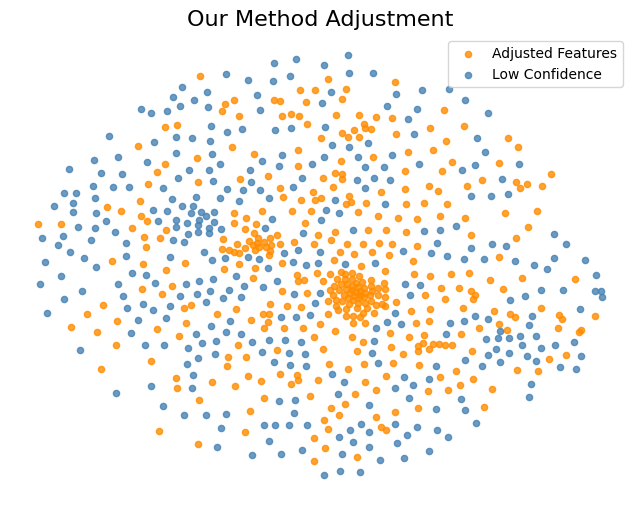

In [137]:
# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(adourfeatsne_1[:, 0], adourfeatsne_1[:, 1], s=20, alpha=0.8, c='darkorange', label='Adjusted Features')
plt.scatter(unourfeatsne_1[:, 0], unourfeatsne_1[:, 1], s=20, alpha=0.8, c='steelblue', label='Low Confidence')

# 绘制平滑的曲线
#plt.plot(x_smooth, y_smooth, color='red', linewidth=2, linestyle='--', label='Smoothed Convex Hull')
plt.axis('off')
# 添加标题和标签
plt.title('Our Method Adjustment', fontsize=16)
#plt.xlabel('t-SNE Component 1')
#plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.savefig('fig3_ouradjust.png', dpi=300)  
plt.show()
plt.close()

In [38]:
our_cnt

array([287731, 760117, 108598, 195601])

In [39]:
unour_cnt

array([25105, 76038, 11796, 19094])

In [42]:
reli_cnt

array([84210, 76246, 34416, 99658])

In [43]:
unreli_cnt

array([228626, 759909,  85978, 115037])

In [46]:
our_cnt / (our_cnt + unour_cnt)

array([0.91975028, 0.90906232, 0.9020217 , 0.91106453])

In [47]:
reli_cnt / (reli_cnt + unreli_cnt)

array([0.26918257, 0.09118644, 0.28586142, 0.46418408])

In [7]:
import torch
import pandas as pd

# 创建一个示例 PyTorch 张量
tensor = torch.stack([torch.stack(i) for i in posi_list]).transpose(0, 1)  # 例如，一个 1200x4 的张量

# 将张量转换为 NumPy 数组
numpy_array = tensor.cpu().detach().numpy()

# 将 NumPy 数组转换为 Pandas DataFrame
df = pd.DataFrame(numpy_array)

# 保存 DataFrame 为 CSV 文件
df.to_csv('output_prob.csv', index=False, header=False)  # index=False 表示不保存行索引，header=False 表示不保存列名

In [5]:
for batch_idx, (ppg, sig, fea, label, frag_label, ahi_label) in enumerate(train_loader):

    y_frag = frag_label.squeeze(0)
    y = label.squeeze(0)
    ahi_label = ahi_label.squeeze(0)
    
    y = y #+ y_frag * 4 + ahi_label * 8

    y = y.long().to(device)
    
    ppg = ppg.to(device)
    sig = sig.to(device)
    fea = fea.to(device)
    outputs = model(ppg, sig, fea)
    
    if type(outputs) in (tuple, list):
        
        feature, outputs = outputs[0], outputs[1]

    else:
        feature = outputs

    feature = feature[0, :y.shape[0], :]
    outputs = outputs[0, :y.shape[0], :]

    #value, predicted = torch.max(outputs[:, :].data, dim=1)
    posi_list = list()
    for i in range(4):
        posi_list.append(list())
    
    n = len(outputs)
    
    prob_tea_i = outputs.clone()
    
    entropy_i = - torch.sum(prob_tea_i * torch.log(prob_tea_i + 1e-10), dim=1)
    entropy_i = (entropy_i-entropy_i.min())/(entropy_i.max()-entropy_i.min())
    '''for i in range(4):
        for j in range(len(prob_tea_i)):
            posi_list[i].append(prob_tea_i[j][i]-entropy_i[j])
    '''
    for i in range(4):
        for j in range(len(prob_tea_i)):
            posi_list[i].append(prob_tea_i[j][i]-entropy_i[j])
    
    posi_list = torch.clamp(torch.stack([torch.stack(i) for i in posi_list]), min=0).detach()
    our = posi_list.any(axis = 0)
    
    low_k = int(n * 0.2)
    low_k =  torch.kthvalue(entropy_i, low_k ).values
    value, predicted = torch.max(outputs[:, :].data, dim=1)
    reli = entropy_i < low_k

    for i in range(len(y)):
        if(reli[i]):
            reli_cnt[y[i]] = reli_cnt[y[i]] + 1
        else:
            unreli_cnt[y[i]] = unreli_cnt[y[i]] + 1

        if(our[i]):
            our_cnt[y[i]] = our_cnt[y[i]] + 1
        else:
            unour_cnt[y[i]] = unour_cnt[y[i]] + 1
        
    #train_loss = 0
    print(batch_idx)

In [29]:
peo_li = list()
color = list()

true_label = list()

In [30]:
for batch_idx, (ppg, sig, fea, label, frag_label, ahi_label) in enumerate(train_loader):
    if(batch_idx <27): # 22
        continue
    if(batch_idx ==30): # 22
        break
    y_frag = frag_label.squeeze(0)
    y = label.squeeze(0)
    ahi_label = ahi_label.squeeze(0)
    
    y = y #+ y_frag * 4 + ahi_label * 8

    y = y.long().to(device)
    
    ppg = ppg.to(device)
    sig = sig.to(device)
    fea = fea.to(device)
    outputs = model(ppg, sig, fea)
    
    if type(outputs) in (tuple, list):
        
        feature, outputs = outputs[0], outputs[1]

    else:
        feature = outputs

    feature = feature[0, :y.shape[0], :]
    outputs = outputs[0, :y.shape[0], :]
 
    prob_fea = feature
    
    #value, predicted = torch.max(outputs[:, :].data, dim=1)
    posi_list = list()
    for i in range(4):
        posi_list.append(list())
    
    n = len(outputs)
    
    prob_tea_i = outputs.clone()
    
    entropy_i = - torch.sum(prob_tea_i * torch.log(prob_tea_i + 1e-10), dim=1)
    entropy_i = (entropy_i-entropy_i.min())/(entropy_i.max()-entropy_i.min())

    for i in range(4):
        for j in range(len(prob_tea_i)):
            posi_list[i].append(prob_tea_i[j][i]-entropy_i[j])
    
    posi_list = torch.clamp(torch.stack([torch.stack(i) for i in posi_list]), min=0).detach()

    our = list()
    for i in range(4):
        our.append(list())
    
    low_k = int(n * 0.2)
    low_k =  torch.kthvalue(entropy_i, low_k ).values
    value, predicted = torch.max(outputs[:, :].data, dim=1)
    reli = entropy_i < low_k

    #contract loss
    for i in range(4):    
        lab_mean = torch.sum(posi_list[i].unsqueeze(1) * prob_fea, axis = 0)/torch.sum(posi_list[i])
        #lab_mean = lab_mean.detach()
        
        temp = (posi_list[i].unsqueeze(1) * prob_fea + (1 - posi_list[i]).unsqueeze(1) * lab_mean)#[posi_list[i]>0]

        our[i].append(temp)


    
    for i in range(len(y)):
        peo_li.append(feature[i].cpu().detach().numpy())
        color.append(batch_idx-20)
        true_label.append(y[i])
    print(batch_idx)
    '''
    for i in range(len(y)):
        refea.append(feature[i].cpu().detach().numpy())
        if(reli[i]):
            relabel.append(predicted[i].cpu())#0, 1, 2, 3, 4        预测的四类&低置信度
        else:
            relabel.append(4)
        
        ourfea.append(feature[i].cpu().detach().numpy())#0, 1, 2, 3, 4        预测的四类&低置信度
        if(posi_list[:, i].any()):
            ourlabel.append(predicted[i].cpu())
        else:
            ourlabel.append(4)

        flag = True
        for j in range(4):
            if(posi_list[j][i]):
                adourfea.append(our[j][0][i].cpu().detach().numpy())
                adourlabel.append(j)
                flag = False
        if(flag):
            adourfea.append(feature[i].cpu().detach().numpy())
            adourlabel.append(4)
    '''
    '''
    for i in range(len(y)):
        if(y[i]==1):
            if(reli[i]):
                refea_1.append(feature[i])#0, 1, 2, 3, 4        预测的四类&低置信度
            else:
                unrefea_1.append(feature[i])

            if(posi_list[1][i]):
                ourfea_1.append(feature[i])#0, 1, 2, 3, 4        预测的四类&低置信度
                adourfea_1.append(our[i])
            else:
                unourfea_1.append(feature[i])
    '''
    #train_loss = 0

27
28
29


In [388]:
np.stack(peo_li).shape

(1000, 768)

In [16]:
len(color)

3178

In [17]:
len(data_tsne)

3178

In [23]:
import seaborn as sns

In [81]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev

import matplotlib.cm as cm

# 假设你有一些数据
data = all  # 100个样本，50个特征

# 使用 t-SNE 降维
tsne = TSNE(n_components=2)#, random_state=)
#data_tsne = tsne.fit_transform(data)

data_tsne = tsne.fit_transform( np.stack(peo_li) )

temp = torch.tensor(true_label)

In [414]:
data_tsne.shape

(1000, 2)

In [82]:
color = np.empty(len(data_tsne), dtype='object')
lab = np.empty(len(data_tsne), dtype='object')
mar = np.empty(len(data_tsne), dtype='object')

In [83]:
for i in range(len(data_tsne)):
    lab[i] = int(i/100)
    color[i] = int(i/100)

In [24]:
torch.unique(temp)

tensor([0, 1, 2, 3])

In [84]:
marker = list()
for i in range(len(temp)):
    if temp[i] == 0:
        marker.append('v')
    if temp[i] == 1:
        marker.append('^')
    if temp[i] == 2:
        marker.append('+')
    if temp[i] == 3:
        marker.append('x')

In [15]:
color = np.array(color)

In [11]:
temp[color==7][temp[color==7]==1].shape

torch.Size([0])

In [76]:
cm.cool([0, 1, 2, 3])[2]

array([0.00784314, 0.99215686, 1.        , 1.        ])

In [19]:
len(data_tsne)

2749

In [27]:
np.zeros([3,4,2]).shape

(3, 4, 2)

In [29]:
data_tsne[:,0][color==7][temp[color==7]==0].mean()

-19.630306

In [10]:
np.unique(color)[i]

IndexError: index 2540 is out of bounds for axis 0 with size 26

In [85]:
peo_stage = np.zeros([3,4,2])

ind = np.unique(color)
for i in range(3):
    for j in range(4):
        peo_stage[i][j][0] = data_tsne[:,0][color==ind[i]][temp[color==ind[i]]==j].mean()
        peo_stage[i][j][1] = data_tsne[:,1][color==ind[i]][temp[color==ind[i]]==j].mean()

/tmp/ipykernel_3748370/2971280707.py:6: RuntimeWarning: Mean of empty slice.
  peo_stage[i][j][0] = data_tsne[:,0][color==ind[i]][temp[color==ind[i]]==j].mean()
/extern2/zgz/.conda/envs/wq/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3748370/2971280707.py:7: RuntimeWarning: Mean of empty slice.
  peo_stage[i][j][1] = data_tsne[:,1][color==ind[i]][temp[color==ind[i]]==j].mean()


In [8]:
data_tsne.shape

(1020, 2)

In [76]:
peo_stage

array([[[ 6.42604923, -2.61037302],
        [-3.67313838, -3.70092583],
        [ 4.66579914, -0.62426871],
        [-1.10144043,  4.18306446]],

       [[ 3.54510617, -2.40129161],
        [ 2.18588591,  0.1907693 ],
        [ 9.6919241 ,  5.75605869],
        [ 7.57440853,  7.97355032]],

       [[ 2.12950158, -3.8671205 ],
        [-4.40851355, -3.59236312],
        [-1.71969938,  0.43590167],
        [ 0.03236723,  8.26931286]]])

In [52]:
peo_stage

array([[[-0.09295918,  2.91345096],
        [ 0.89468801, -2.1775713 ],
        [ 0.38182947, -3.10645556],
        [ 6.58260822,  6.67576218]],

       [[-3.00834179, -0.41271278],
        [ 5.12676144, -4.26743269],
        [ 3.07812643, -3.10747337],
        [32.82755661,  4.87064743]],

       [[ 5.09809256, -1.40855527],
        [-1.96018398,  0.86472362],
        [-5.92705536,  2.82354188],
        [21.10792732,  2.19900203]]])

In [32]:
peo_stage

array([[[-19.63030624,  38.35095978],
        [-14.53355408,  -2.10323286],
        [  8.05458736, -51.55334091],
        [ 31.45611954, -10.7059288 ]],

       [[-10.63950443,  43.31266403],
        [ -0.74253523,   3.84050488],
        [  3.601089  , -17.90077972],
        [ 45.10160446,  -7.91130972]],

       [[-16.27369118,  29.23965263],
        [ -7.96336412,   3.60063624],
        [-36.36307144, -26.92619324],
        [ 51.66016006,  -8.60364819]]])

In [23]:
peo_stage = np.array([[[-19.63030624,  38.35095978], [-14.53355408,  -2.10323286], [8.05458736, -51.55334091], [ 31.45611954, -10.7059288 ]],
        [[-10.63950443,  43.31266403], [ -0.74253523,   3.84050488], [  3.601089  , -17.90077972],[ 45.10160446,  -7.91130972]],
        [[-16.27369118,  29.23965263], [ -7.96336412,   3.60063624], [-36.36307144, -26.92619324], [ 51.66016006,  -8.60364819]]])

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

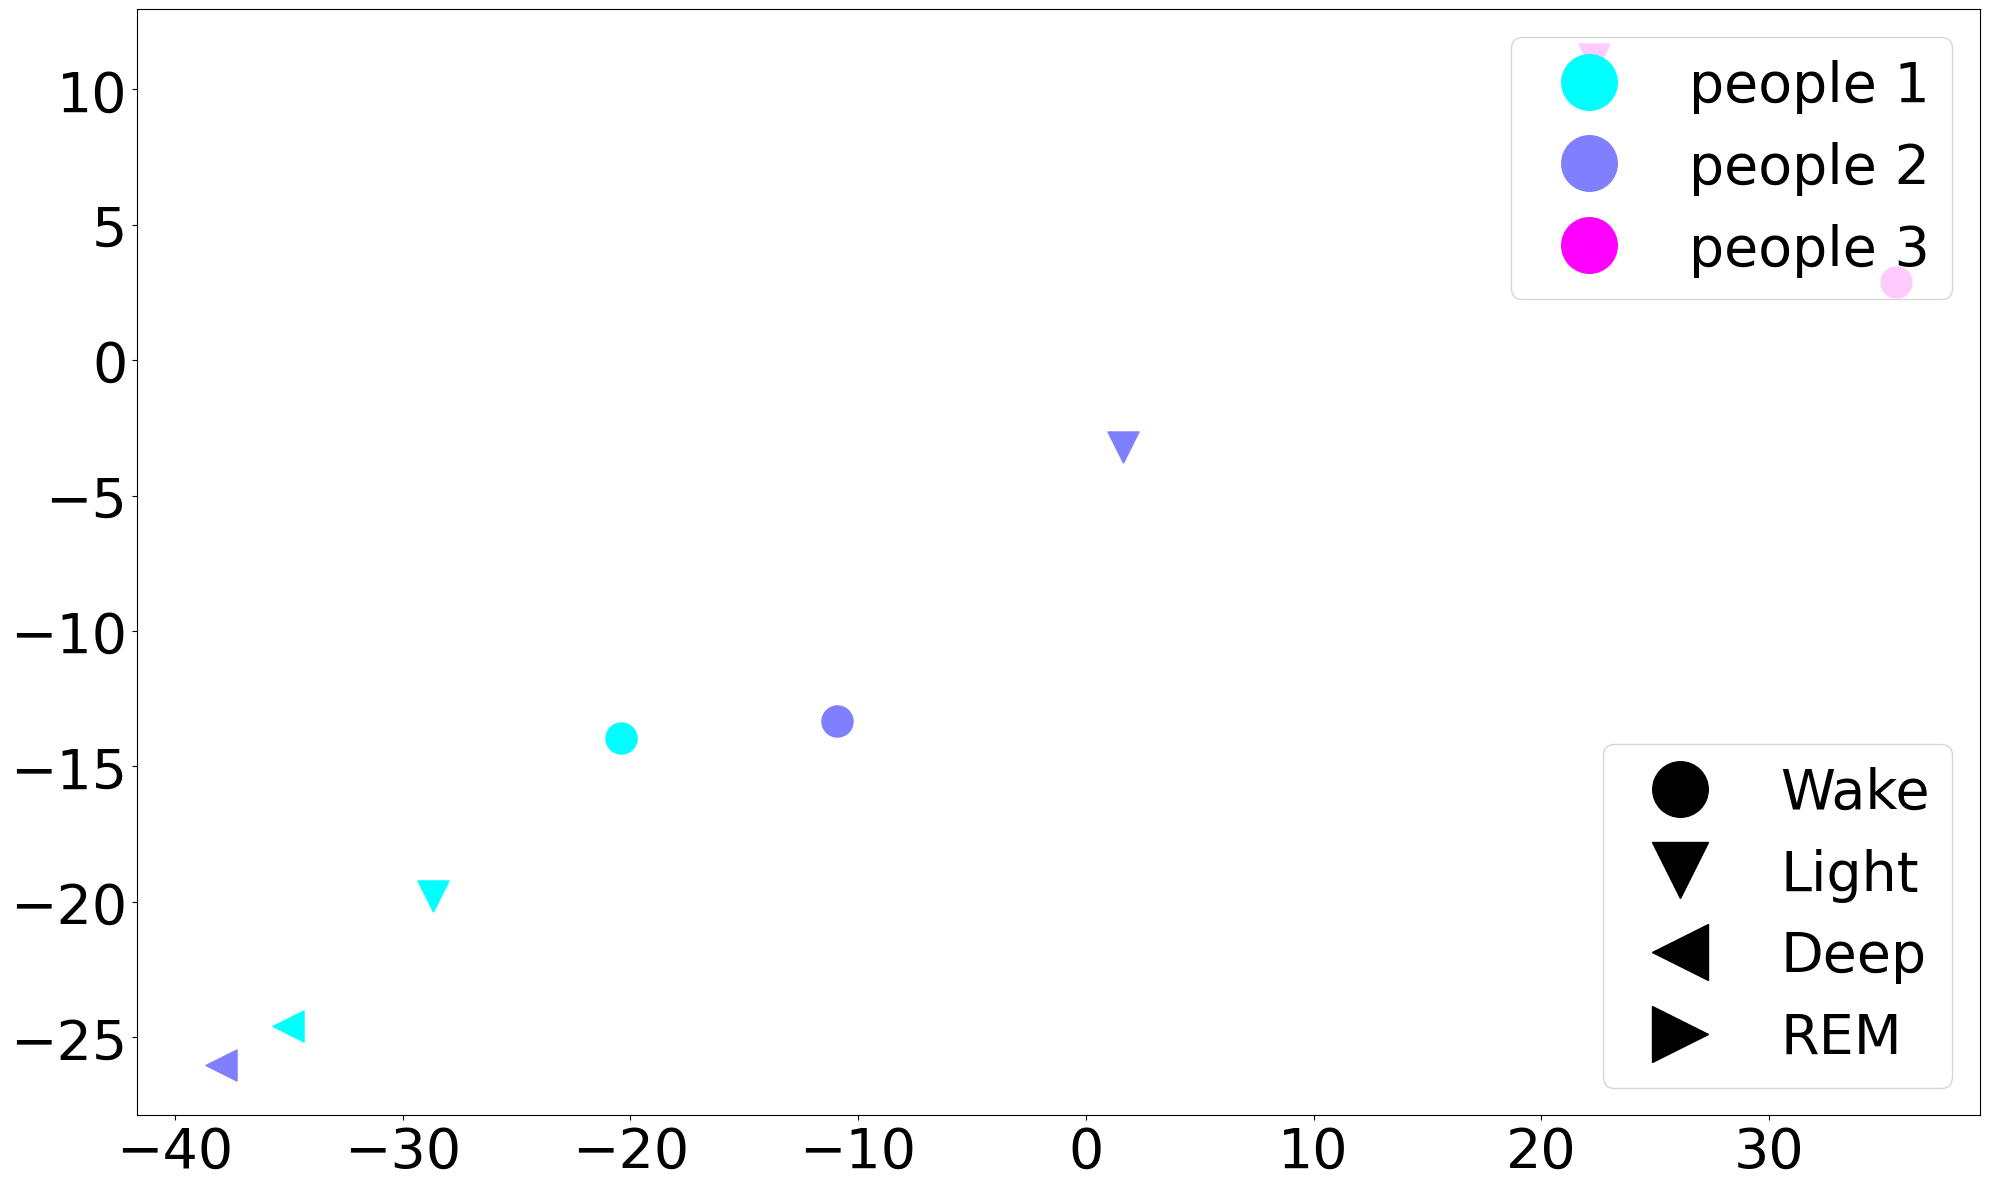

In [91]:
from matplotlib.font_manager import FontProperties

from matplotlib.lines import Line2D
classes = ['people 1', 'people 2', 'people 3']
mark = ['o', 'v', '<', '>']
shape_labels = ['Wake', 'Light', 'Deep', 'REM'] 

mark = ['o', 'v', '<', '>']

fig = plt.figure(figsize=(20,12))
for i in range(3):
    for j in range(4):
        if(j==0):
            plt.scatter(peo_stage[i][j][0], peo_stage[i][j][1], marker = mark[j], color = cm.cool([0, 0.5, 1])[i], s = 500, label= classes[i])
        else:
            plt.scatter(peo_stage[i][j][0], peo_stage[i][j][1], marker = mark[j], color = cm.cool([0, 0.5, 1])[i], s = 500)

#scatter = plt.scatter(data_tsne[:,0][color==7][temp[color==7]==0], data_tsne[:,1][color==7][temp[color==7]==0], marker = 'v', color = cm.cool([0, 0.33, 0.66, 1])[0])#, c = temp[color==7][temp[color==7]==1], cmap = 'cool')#plt.colorbar(), color
#scatter = plt.scatter(data_tsne[:,0][color==7][temp[color==7]==1], data_tsne[:,1][color==7][temp[color==7]==1], marker = 'v', color = cm.cool([0, 0.33, 0.66, 1])[1])#, c = temp[color==7][temp[color==7]==2], cmap = 'cool')#plt.colorbar(), color
#scatter = plt.scatter(data_tsne[:,0][color==7][temp[color==7]==2], data_tsne[:,1][color==7][temp[color==7]==2], marker = 'v', color = cm.cool([0, 0.33, 0.66, 1])[2])#, c = temp[color==7][temp[color==7]==3], cmap = 'cool')#plt.colorbar(), color
#scatter = plt.scatter(data_tsne[:,0][color==7][temp[color==7]==3], data_tsne[:,1][color==7][temp[color==7]==3], marker = 'v', color = cm.cool([0, 0.33, 0.66, 1])[3])#, c = temp[color==7][temp[color==7]==3], cmap = 'cool')#plt.colorbar(), color



#lines, labels = fig.axes[-1].get_legend_handles_labels()   
#fig.legend(lines, labels=classes, loc="upper right", markerscale=1, fontsize=40)

#plt.show()

color_handles = [
    Line2D([0], [0],
           marker=mark[0],         # 统一用第一个形状
           color=plt.cm.cool([0, 0.5, 1])[i],
           markersize=40,
           linestyle='None',
           label=classes[i])
    for i in range(3)
]

shape_handles = [
    Line2D([0], [0],
           marker=mark[j],
           color='black',
           markersize=40,
           linestyle='None',
           label=shape_labels[j])
    for j in range(4)
]

leg1 = plt.legend(handles=color_handles, 
                 loc='upper right', 
                 fontsize=40)
                 #title="Color Legend",
                 #title_fontsize=40)

# 添加形状图例到右侧外部
plt.gca().add_artist(leg1)  # 防止被覆盖


plt.legend(handles=shape_handles, loc='lower right', fontsize=40)

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_size(40)

plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)

plt.tight_layout()

plt.axis('on')
#plt.title("T-SNE dimensionality reduction feature", fontsize=16)

#plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc="upper right", markerscale=4, fontsize=40)

#plt.show()
fig.savefig( "after_seq_20.png", dpi=300)

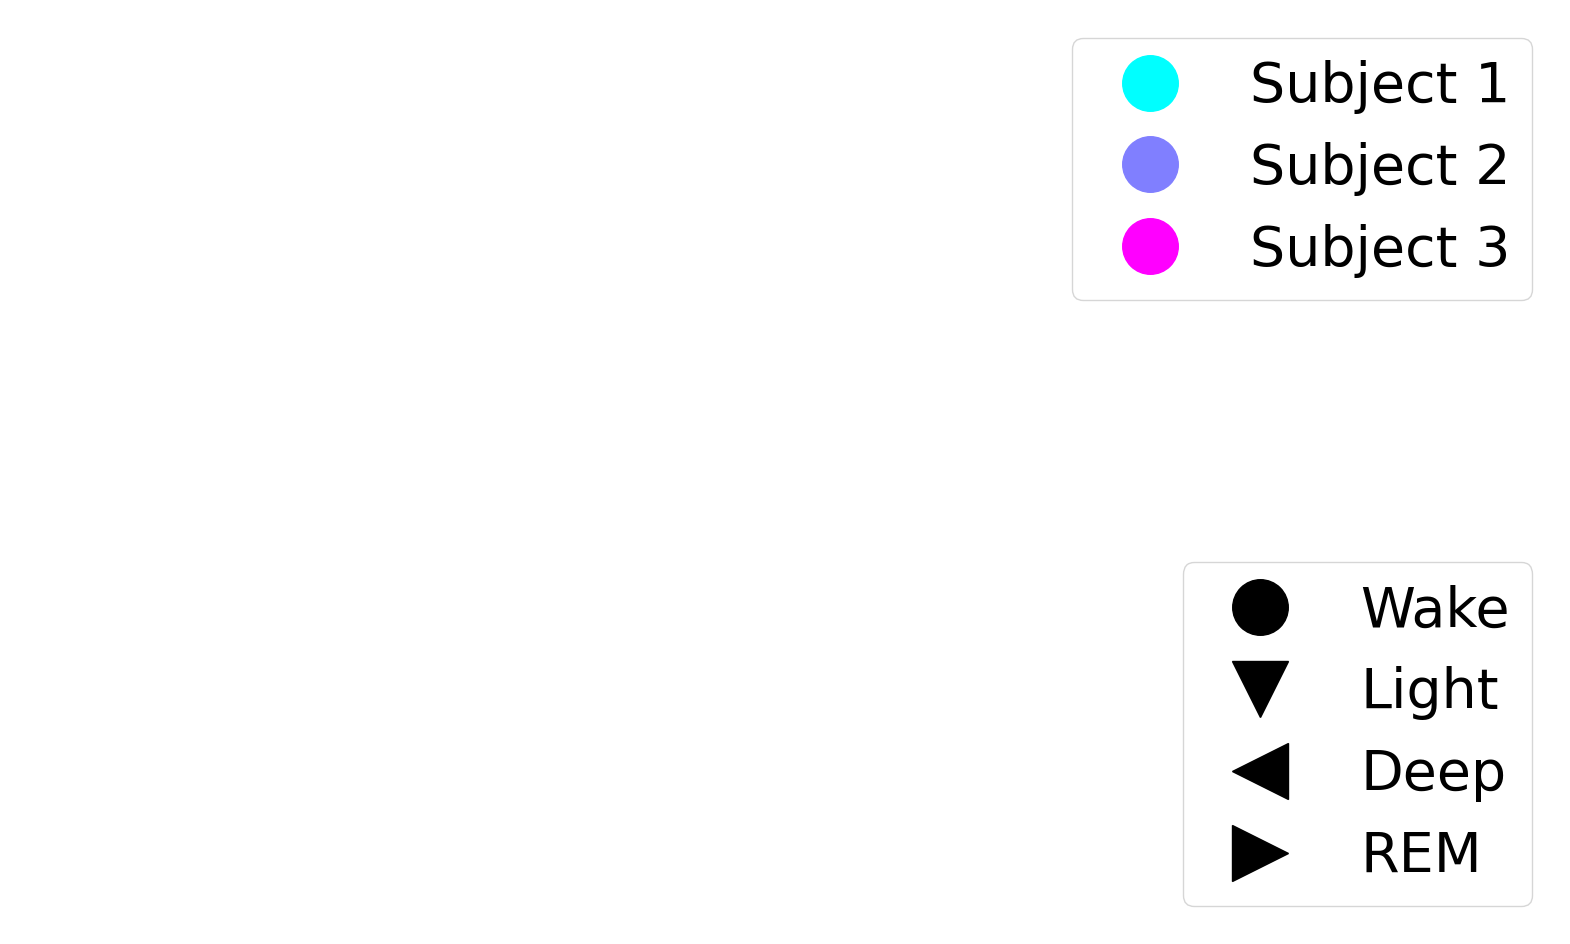

In [88]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

classes = ['Subject 1', 'Subject 2', 'Subject 3']
mark = ['o', 'v', '<', '>']
shape_labels = ['Wake', 'Light', 'Deep', 'REM']  # 定义形状的标签

fig = plt.figure(figsize=(20, 12))

# 绘制所有散点
for i in range(3):
    for j in range(4):
        color = plt.cm.cool([0, 0.5, 1])[i]  # 颜色按class变化
        if j == 0:
            '''plt.scatter(peo_stage[i][j][0], peo_stage[i][j][1], 
                        marker=mark[j], 
                        color=color, 
                        s=500, 
                        label=classes[i])  # 仅颜色图例标签'''
        else:
            '''plt.scatter(peo_stage[i][j][0], peo_stage[i][j][1], 
                        marker=mark[j], 
                        color=color, 
                        s=500)'''

# 创建颜色图例的句柄（用第一个形状）
color_handles = [
    Line2D([0], [0],
           marker=mark[0],         # 统一用第一个形状
           color=plt.cm.cool([0, 0.5, 1])[i],
           markersize=40,
           linestyle='None',
           label=classes[i])
    for i in range(3)
]

# 创建形状图例的句柄（用黑色）
shape_handles = [
    Line2D([0], [0],
           marker=mark[j],
           color='black',
           markersize=40,
           linestyle='None',
           label=shape_labels[j])
    for j in range(4)
]

# 添加颜色图例到右上角
leg1 = plt.legend(handles=color_handles, 
                 loc='upper right', 
                 fontsize=40)
                 #title="Color Legend",
                 #title_fontsize=40)

# 添加形状图例到右侧外部
plt.gca().add_artist(leg1)  # 防止被覆盖
leg2 = plt.legend(handles=shape_handles, 
                 loc='lower right', fontsize=40)
                 #bbox_to_anchor=(1.05, 1),  # 右侧外部
                 
                 #title="Shape Legend",
                 #title_fontsize=40)

plt.axis('off')
#plt.tight_layout(rect=[0, 0, 0.85, 1])  # 右侧留出15%空间
fig.savefig("after_seq_20.png", dpi=300, bbox_inches='tight')  # 确保图例完整

In [25]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the Axes.
    
    Call signatures::
    
        legend()
        legend(handles, labels)
        legend(handles=handles)
        legend(labels)
    
    The call signatures correspond to the following different ways to use
    this method:
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    .. note::
        Specific artists can be excluded from the automatic leg

/tmp/ipykernel_3509053/1126316022.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lines, labels=classes, loc="upper right", markerscale=4, fontsize=40)


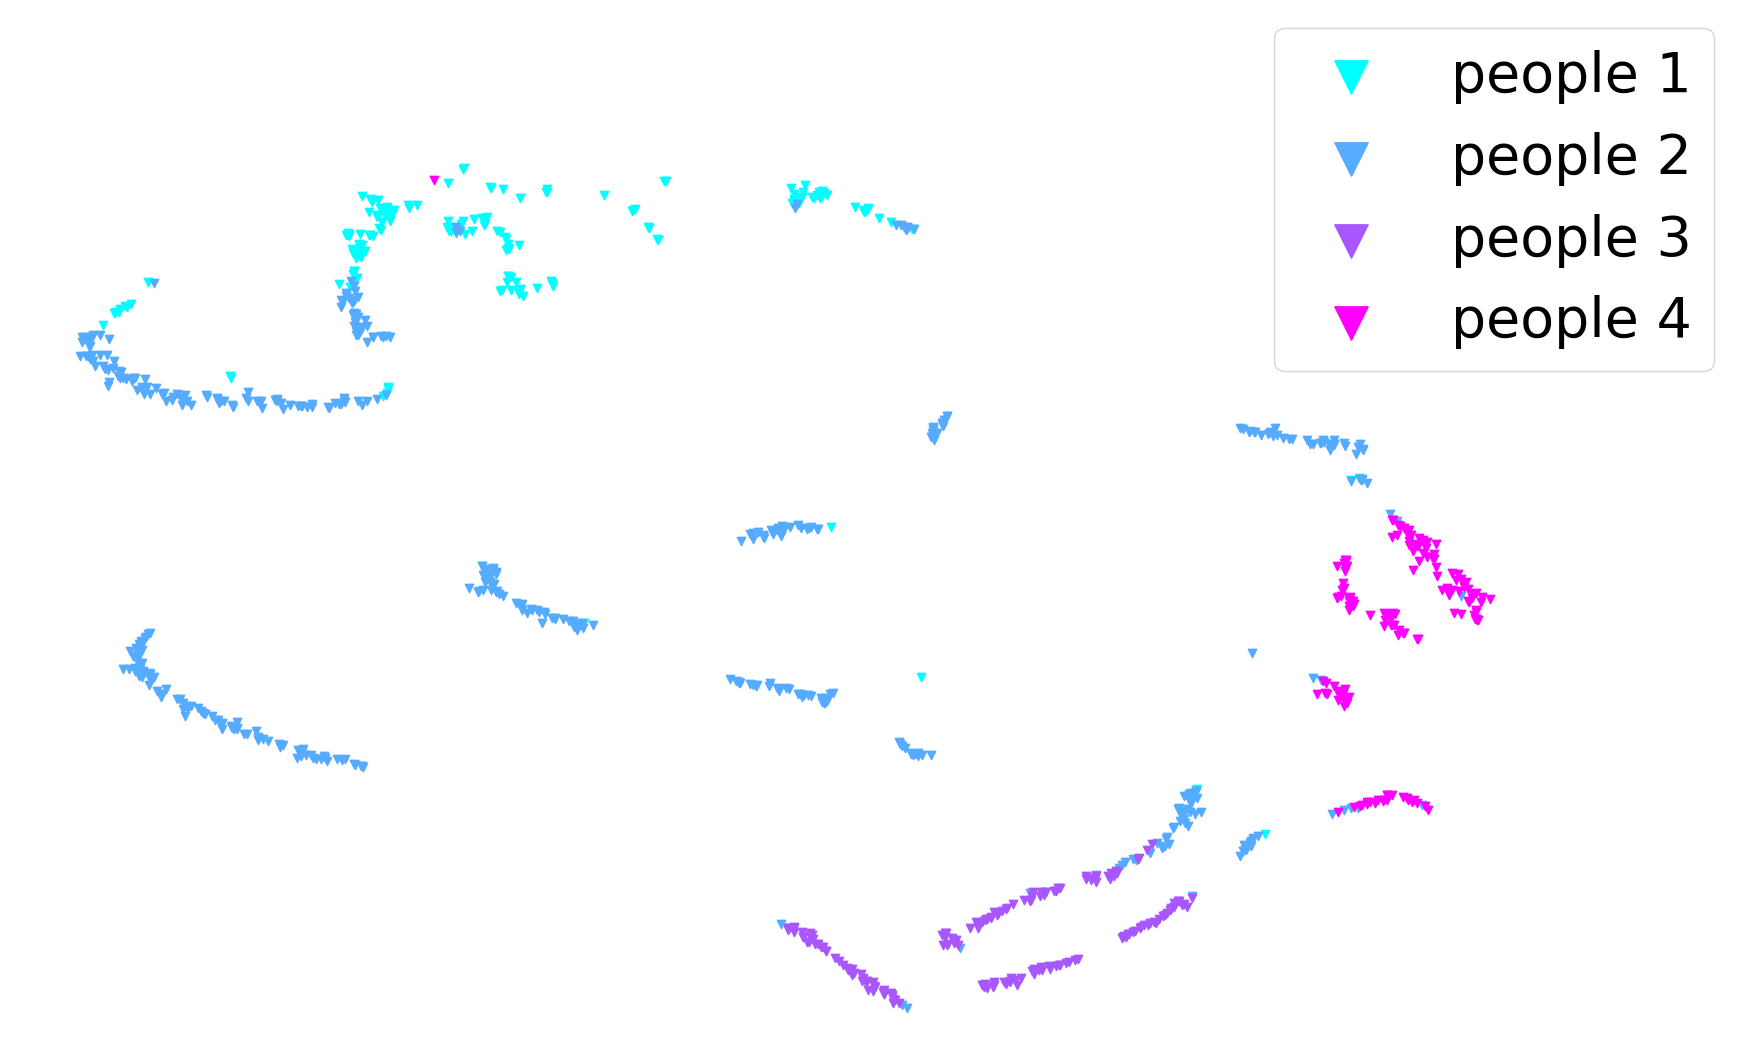

In [25]:
classes = ['people 1','people 2', 'people 3', 'people 4']

fig = plt.figure(figsize=(20,12))
scatter = plt.scatter(data_tsne[:,0][color==7][temp[color==7]==0], data_tsne[:,1][color==7][temp[color==7]==0], marker = 'v', color = cm.cool([0, 0.33, 0.66, 1])[0])#, c = temp[color==7][temp[color==7]==1], cmap = 'cool')#plt.colorbar(), color
scatter = plt.scatter(data_tsne[:,0][color==7][temp[color==7]==1], data_tsne[:,1][color==7][temp[color==7]==1], marker = 'v', color = cm.cool([0, 0.33, 0.66, 1])[1])#, c = temp[color==7][temp[color==7]==2], cmap = 'cool')#plt.colorbar(), color
scatter = plt.scatter(data_tsne[:,0][color==7][temp[color==7]==2], data_tsne[:,1][color==7][temp[color==7]==2], marker = 'v', color = cm.cool([0, 0.33, 0.66, 1])[2])#, c = temp[color==7][temp[color==7]==3], cmap = 'cool')#plt.colorbar(), color
scatter = plt.scatter(data_tsne[:,0][color==7][temp[color==7]==3], data_tsne[:,1][color==7][temp[color==7]==3], marker = 'v', color = cm.cool([0, 0.33, 0.66, 1])[3])#, c = temp[color==7][temp[color==7]==3], cmap = 'cool')#plt.colorbar(), color

plt.axis('off')

lines, labels = fig.axes[-1].get_legend_handles_labels()   
fig.legend(lines, labels=classes, loc="upper right", markerscale=4, fontsize=40)
#plt.show()

#plt.title("T-SNE dimensionality reduction feature", fontsize=16)

#plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc="upper right", markerscale=4, fontsize=40)

#plt.show()
fig.savefig( "fea_seq_new.png", dpi=300)

In [ ]:
#tsne = TSNE(n_components=2, perplexity=30.0, init='pca', random_state=42)
#X_transformed = tsne.fit_transform(X)
label_name = ["63","66","69","72","75","78","81",
              "84","87","90","93","96","99","102",
              "105","108","111","114","117","120","123",
              "126","129","132","135","138","141","144"]
fig = plt.figure(figsize=(20,12))

color = np.empty(len(y_trans1), dtype='object')
lab = np.empty(len(y_trans1), dtype='object')
mar = np.empty(len(y_trans1), dtype='object')
marker = ["o", "o", "o", "o", "o", "o","o",
          "o", "o", "o", "o", "o", "o","o",
          "^", "^", "^", "^", "^", "^","^",
          "^", "^", "^", "^", "^", "^","^"]

for label in np.unique(y_trans1[:,1]):
    color[label==y_trans1[:,1]] = label*3+66
    lab[label==y_trans1[:,1]] = str(int(label*3+66))
    #mar[label==y_trans1] = marker[int(label)]
#marker=mar,

plt.colorbar(plt.scatter(x_trans1[:,0], x_trans1[:,1], label=lab,  c = color ,cmap = 'cool'))
plt.title("T-SNE dimensionality reduction feature")
plt.legend(loc="upper left")
#plt.show()
fig.savefig(os.path.join(save_path, "tsne_picture.png"))